<a href="https://colab.research.google.com/github/AlexanderVaz15/Final_16B/blob/main/BullFolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BullFolio**

Joseph Kiger, Wildan Levitt, Alexander Vazquez

github: https://github.com/wildanlevitt/16B_BullFolio


# Joseph stuff

In [ ]:
import full_nmf_pipeline.py
import pandas as pd
import numpy as np
import yfinance as yf  # to fetch historical price data
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from sklearn.decomposition import PCA
# Step 1: Data Collection
import yfinance as yf
class StockPortfolio:
    '''
    This class is to help us manage data regarding a given list of stock tickers
    tickList: list or string of our stock tickers
    tickerList: Dictionary of our ticker names with the yf ticker object
    timePeriod: how far we want to look back on historical data,  must be one of: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max ,,, defaulting to 1 year
    data: A dataframe provided by yahoo finance api that gives us the daily open, close, adjusted close prices, highs and lows, and trading volume
            information for our tickers during a specified time period
    '''
    def __init__(self, tickList):
        self.tickerList = yf.Tickers(tickList).tickers
        self.timePeriod = '1y'
        self.data = yf.download(list(self.tickerList.keys()), period = self.timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
    def getSimpleChangeHistory(self, feature: str) -> pd.DataFrame:
        '''
        feature is what feature we want to see the % change in for that day, eg Close Price, Volume, Open Price
        This method calculates the daily closing price pct changes,
        calculated by taking the difference between the kth and (k-1)th day's non-adjusted closing price
        then dividing this difference by the (k-1)th close price to find the pct change after the kth day's market close
        '''
        #data = yf.download(list(self.YfTickers.keys()), period = timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
        self.simpleReturn = self.data[(feature,)].pct_change().dropna()
        return self.simpleReturn
    def getLogChangeHistory(self, feature: str) -> pd.DataFrame:
        '''
        This Method calculates the log return for each day, ln(Close Price of Today/close price of yesterday)
        '''
        self.logReturn = np.log(self.data[(feature,)]) - np.log(self.data[(feature,)].shift(1)).dropna()
        return self.logReturn
    def change_timePeriod(self, newTimePeriod: str) -> None:
        '''
        This method changes the time period for the historical data we want to look at
        '''
        self.timePeriod = newTimePeriod
        self.data = yf.download(list(self.tickerList.keys()), period = self.timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
        '''
    def simpleReturnVolatility(self) -> float:
        We Actually don't need this
        mean = self.getSimpleReturnHistory().mean()
        std = self.getSimpleReturnHistory().std()
        return std
    def logReturnVolatility(self) -> float:
        I don't think we need this either
        mean = self.getLogReturnHistory().mean()
        std = self.getLogReturnHistory().std()
        return std
        '''
    def simpleMovingAverage(self,  feature: str, dayWindow: int) -> pd.DataFrame:
        '''
        This method calculates the Simple Moving Average for a specific time window of our non-adjusted Close Prices
        '''
        return self.data[(feature, )].rolling(window = dayWindow).mean()
    def exponentialMovingAverage(self, feature: str, dayWindow: int) -> pd.DataFrame:
        '''
        feature: Any of the features of our stock data, examples: Volume Close Price

        This method calculates the exponential moving average for a specific time window of our non-adjusted Close Prices
        This one is more weighted by recent prices, so looking at the difference between the Simple Moving and Exponential moving
        can give some insight into the momentum of the price changes
        '''
        return self.data[(feature, )].ewm(span=dayWindow, adjust=False).mean()
    def extractColumns(self, cols:list,tick:list)->pd.DataFrame:
        newData = self.data.loc[:, (cols, tick)]
        return newData
    def plotMovingAveragesDiff(self,feature: str, timeWindow: int, ticker: str) -> go.Figure:
        '''
        This method creates a figure displaying the moving averages and their difference for a desired time window and ticker
        '''
        df1 = self.simpleMovingAverage(feature,timeWindow)
        df2 = self.exponentialMovingAverage(feature,timeWindow)
        df3 = self.exponentialMovingAverage(feature,timeWindow) - self.simpleMovingAverage(feature,timeWindow)
        newDf = pd.DataFrame()
        newDf['SMA'] = df1[ticker]
        newDf['EMA'] = df2[ticker]
        newDf['Diff'] = df3[ticker]
        fig = go.Figure()

        # Add SMA trace (primary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['SMA'], mode='lines', name='SMA'))

        # Add EMA trace (primary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['EMA'], mode='lines', name='EMA'))

        # Add Difference trace (secondary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['Diff'], mode='lines', name='Difference', yaxis='y2'))

        # Update layout for two y-axes
        diff_min = newDf['Diff'].min()
        diff_max = newDf['Diff'].max()
        padding = (diff_max - diff_min) * 0.1  # 10% padding
        fig.update_layout(
            title=f"Simple Moving Average and Exponential Moving Average of {ticker}'s {feature} over {timeWindow} day window, and Their Difference with Dual Y-Axis for {ticker}",
            xaxis=dict(title='Date'),
            yaxis=dict(title='SMA and EMA'),
            yaxis2=dict(
                title='Difference',
                overlaying='y',
                side='right',
                showgrid=False,
                zeroline=True,
                zerolinecolor='gray',
                range=[diff_min - padding, diff_max + padding]
            ),
            legend=dict(x=0, y=-1)
        )
        return fig
    def MovingAverages(self, feature: str, timeWindow: str) -> pd.DataFrame:
        df1 = self.simpleMovingAverage(feature,timeWindow)
        df2 = self.exponentialMovingAverage(feature,timeWindow)
        df3 = self.exponentialMovingAverage(feature,timeWindow) - self.simpleMovingAverage(feature,timeWindow)
        newDf = pd.DataFrame()
        #combined = pd.concat([df1, df2, df3], axis=1, keys=['SMA', 'EMA', 'Diff'])
        #newDf[('SMA',)] = df1
        #newDf[('EMA',)] = df2
        #newDf[('Diff',)] = df3
        combined = pd.concat([df1, df2, df3], axis=1, keys=['SMA', 'EMA', 'Diff'])
        return combined
    def featureAndTargetSplitter(self, shift: int, sampleSize: int, targetFeature: str, movingAverageWindow: int, ticker ) -> (pd.DataFrame,pd.DataFrame):
        '''
        This method uses all of our data to construct our desired target and feature columns and offset the features by a shifted date to predict that many days in advance
        Sample Size is how many data points we want
        '''
        targetData = self.data[(targetFeature,ticker)].tail(len(self.data[(targetFeature,ticker)]) - movingAverageWindow + 1)
        '''
        feature column construction
        '''
        diff = self.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
        volDiff = self.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
        logReturn = self.getLogChangeHistory('Close')[ticker].tail(len(self.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
        volumeData = self.data[('Volume',ticker)].tail(len(self.data[('Volume',ticker)]) - movingAverageWindow + 1)
        closeData = self.data[('Close',ticker)].tail(len(self.data[('Close',ticker)]) - movingAverageWindow + 1)
        openData = self.data[('Open', ticker)].tail(len(self.data[('Open',ticker)]) - movingAverageWindow + 1)
        lowData = self.data[('Low', ticker)].tail(len(self.data[('Low',ticker)]) - movingAverageWindow + 1)
        highData = self.data[('High', ticker)].tail(len(self.data[('High',ticker)]) - movingAverageWindow + 1)

        #index = len(closeData)-2
        #testDay = {'Close':closeData.iloc[index],'Volume':volumeData.iloc[index],'LogReturn':logReturn.iloc[index],'MovingAvgDiffClose':diff.iloc[index],'MovingAvgDiffVol':volDiff.iloc[index]}
        '''
        Looking at the target column after the shift, so that we can then look at the previous indices for the feature columns
        '''
        subset_after_shift = targetData.iloc[shift:]
        sampled_df1 = subset_after_shift.sample(n=sampleSize, random_state=42)
        sampled_df1 = sampled_df1.sort_index()
        sampled_positions = [targetData.index.get_loc(idx) for idx in sampled_df1.index]
        shifted_positions = [pos - shift for pos in sampled_positions]
        valid_shifted_positions = [pos for pos in shifted_positions if pos >= 0]
        selectLogReturn = logReturn.iloc[valid_shifted_positions]
        selectedDiff = diff.iloc[valid_shifted_positions]
        selectVolDiff = volDiff.iloc[valid_shifted_positions]
        selectVolume = volumeData.iloc[valid_shifted_positions]
        selectClose = closeData.iloc[valid_shifted_positions]
        selectOpen = openData.iloc[valid_shifted_positions]
        selectLow = lowData.iloc[valid_shifted_positions]
        selectHigh = highData.iloc[valid_shifted_positions]
        testDf = pd.DataFrame({'LogReturn': selectLogReturn,
                               'MovingAvgDiffClose':selectedDiff,
                               #'MovingAvgDiffVol': selectVolDiff,
                               #'Volume':selectVolume,
                               'Close':selectClose,
                               'Open':selectOpen,
                               'Low':selectLow,
                               'High':selectHigh})
        targetDf = pd.DataFrame({f'Target {targetFeature}':sampled_df1})
        return testDf, targetDf
def standardize(testDf: pd.DataFrame, targetDf: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        '''
        Standardizes 2 pandas dataframes
        '''
        testDf = (testDf - testDf.mean())/testDf.std()
        targetDfmean = targetDf.mean()
        targetDfstd = targetDf.std()
        targetDf = (targetDf - targetDfmean) / targetDfstd
        return testDf, targetDf

In [ ]:
test = StockPortfolio(['MSFT', 'AAPL','GOOG','UNH','NVDA','KO','BA','MDT','MCD','SO','NKE'])
test.change_timePeriod('5y')

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  11 of 11 completed


In [ ]:
tickerList = [
    "AAPL", "MSFT", "AMZN", "GOOG", "META", "TSLA", "JPM", "V", "NVDA",
    "DIS", "NFLX", "PYPL", "INTC", "CSCO", "KO", "PFE", "MRK", "WMT", "BAC",
    "T", "XOM", "CVX", "ORCL", "IBM", "NKE", "MCD", "GE", "BA", "MMM",
    "CAT", "HON", "UPS", "COST", "SBUX", "CVS", "AMGN", "GILD", "TXN", "QCOM",
    "ADP", "LLY", "SPG", "LRCX", "F", "GM", "BKNG", "ZM", "SNAP",
    "CRM", "NOW", "ABNB", "SHOP", "DOCU", "ROKU", "PLTR", "SPCE", "NIO",
    "JD", "BABA", "TSM", "ASML", "SAP", "EA", "TTWO", "SIRI",
    "LYFT", "UBER", "DELL", "HPQ", "AMD", "MU", "SNPS", "TEAM", "OKTA",
    "TWLO", "NET", "DOCU", "MDB", "ZS", "CRWD", "PANW", "FTNT", "CHKP", "OKTA",
    "SHOP", "ETSY", "VEEV", "ALGN", "ILMN", "ISRG", "DXCM", "REGN", "BIIB"
]

In [ ]:
bigTest = StockPortfolio(tickerList)
bigTest.change_timePeriod('5y')
bigTest.data

[*********************100%***********************]  90 of 90 completed
[*********************100%***********************]  90 of 90 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABNB         ADP        ALGN         AMD   
Date                                                                     
2020-12-11  119.160301  139.250000  157.434143  507.079987   91.650002   
2020-12-14  118.547028  130.000000  157.089371  504.309998   94.779999   
2020-12-15  124.485092  124.800003  159.448212  516.299988   97.120003   
2020-12-16  124.416954  137.990005  159.303024  516.340027   96.849998   
2020-12-17  125.283325  147.050003  160.890717  526.719971   96.839996   
...                ...         ...         ...         ...         ...   
2025-12-04  280.700012  120.820000  259.399994  156.839996  215.979996   
2025-12-05  278.779999  124.320000  261.630005  157.210007  217.970001   
2025-12-08  277.890015  122.010002  258.690002  157.679993  221.110001   
2025-12-09  277.179993  125.389999  258.230011  159.000000  221.619995   
2025-12-10  278.779999  127.570000  259.339996  164.580002  221.419998   

Price                                                                    ...  \
Ticker            AMGN        AMZN         ASML          BA        BABA  ...   
Date                                                                     ...   
2020-12-11  194.274673  155.820999   432.668274  230.330002  251.232330  ...   
2020-12-14  196.034637  157.848495   433.012360  228.619995  243.150406  ...   
2020-12-15  196.948746  158.255997   448.603119  229.500000  242.276688  ...   
2020-12-16  195.163193  162.048004   450.734772  225.869995  248.715652  ...   
2020-12-17  197.555344  161.804001   456.250275  221.240005  251.127838  ...   
...                ...         ...          ...         ...         ...  ...   
2025-12-04  340.160004  229.110001  1110.079956  201.869995  157.440002  ...   
2025-12-05  329.890015  229.529999  1099.469971  201.889999  158.320007  ...   
2025-12-08  321.230011  226.889999  1119.689941  206.270004  158.130005  ...   
2025-12-09  313.850006  227.919998  1111.439941  200.369995  155.960007  ...   
2025-12-10  315.380005  231.779999  1119.319946  198.720001  158.820007  ...   

Price        Volume                                                           \
Ticker         TWLO      TXN      UBER      UPS         V     VEEV       WMT   
Date                                                                           
2020-12-11  3157100  4145800  16817900  4777500   9227600   690900  16860900   
2020-12-14  2835100  5994200  19048500  3388700  11967700   686500  25088100   
2020-12-15  2370200  5732100  17504700  2555300   9796100   873900  31871400   
2020-12-16  2115500  3147900  19577800  3421600   7504400   480300  25650900   
2020-12-17  2449200  5253400  19688300  4386900   6517200  1009900  30679500   
...             ...      ...       ...      ...       ...      ...       ...   
2025-12-04  2579700  6724100  13145300  9451300   6277500  1768000  25905100   
2025-12-05  2672200  6584600  11154600  5523600   5266600  1389200  23956400   
2025-12-08  2020700  6427600  12646900  5617400   6059400  1690100  22700700   
2025-12-09  1813200  3760400  17117500  4738300   4325400  2077800  24326700   
2025-12-10  2511600  5268100  51120300  7180300   5464900  2246800  22848700   

Price                                   
Ticker           XOM       ZM       ZS  
Date                                    
2020-12-11  25478800  4677400  1851900  
2020-12-14  30595000  6820100  2162500  
2020-12-15  27138400  5144700  1677700  
2020-12-16  34273000  4158500  2119700  
2020-12-17  21204600  3792500  4202600  
...              ...      ...      ...  
2025-12-04  13686900  1728700  1695600  
2025-12-05  12516900  2254900  1772600  
2025-12-08  14904200  2961700  2077300  
2025-12-09  23790800  2536900  1518200  
2025-12-10  19833200  2408600  1691300  

[1255 rows x 540 columns]

In [ ]:
feature = 'Close'
df = test.data[(feature,)]
tick = 'NVDA'
window = 100
test.change_timePeriod('5y')

[*********************100%***********************]  11 of 11 completed


In [ ]:
fig = px.line(df, x = df.index, y = df[df.columns[df.columns.get_loc(tick)]], title = f'{df.columns[df.columns.get_loc(tick)]} {feature} history over {test.timePeriod}')
fig.show()

In [ ]:
test.plotMovingAveragesDiff(feature,window,tick).show()

In [ ]:
test.plotMovingAveragesDiff(feature,window-50,tick).show()

In [ ]:
df = test.getLogChangeHistory(feature)
fig = px.line(df, x = df.index, y = df[df.columns[df.columns.get_loc(tick)]])
fig.show()

In [ ]:
df = test.getSimpleChangeHistory('Close')
fig = px.line(df, x = df.index, y = df.columns)
fig.show()

In [ ]:
df = test.getLogChangeHistory('Volume')
fig = px.line(df, x = df.index, y = df.columns, title = f'Daily Volume Change {bigTest.timePeriod}')
fig.update_layout(yaxis_title="Daily Volume Change")
fig.show()

In [ ]:
feature = 'Volume'
test.change_timePeriod('5y')
window = 100
returns = test.MovingAverages(feature,window)[('Diff',)]
summary_stats = returns.describe().T
summary_stats['skew'] = returns.skew()
summary_stats['kurtosis'] = returns.kurtosis()
corr_matrix = returns.corr()
cov_matrix = returns.cov()

[*********************100%***********************]  11 of 11 completed


In [ ]:
def cross_correlation_lag(x, y, max_lag=10):
    lags = range(-max_lag, max_lag + 1)
    corr = [x.corr(y.shift(lag)) for lag in lags]
    max_corr_idx = np.argmax(np.abs(corr))
    max_corr = corr[max_corr_idx]
    lag = lags[max_corr_idx]
    return lag, max_corr

def identify_leading_lagging_stocks(price_data, window=20, max_lag=10,feature='Close'):
    # Calculate SMA-EMA difference for all stocks
    diff = test.MovingAverages(feature,window)[('Diff',)]

    stocks = price_data.columns
    results = []

    for i in range(len(stocks)):
        for j in range(i+1, len(stocks)):
            stock1 = stocks[i]
            stock2 = stocks[j]
            lag, corr = cross_correlation_lag(diff[stock1], diff[stock2], max_lag)
            if lag > 0:
                lead_lag = f"{stock1} leads {stock2} by {lag} days"
            elif lag < 0:
                lead_lag = f"{stock2} leads {stock1} by {-lag} days"
            else:
                lead_lag = f"{stock1} and {stock2} move simultaneously"
            results.append({"pair": (stock1, stock2), "lag": lag, "correlation": corr, "relationship": lead_lag})

    return pd.DataFrame(results)

In [ ]:
#identify_leading_lagging_stocks(test.data[('Close',)],window,max_lag = 20, feature='Close')

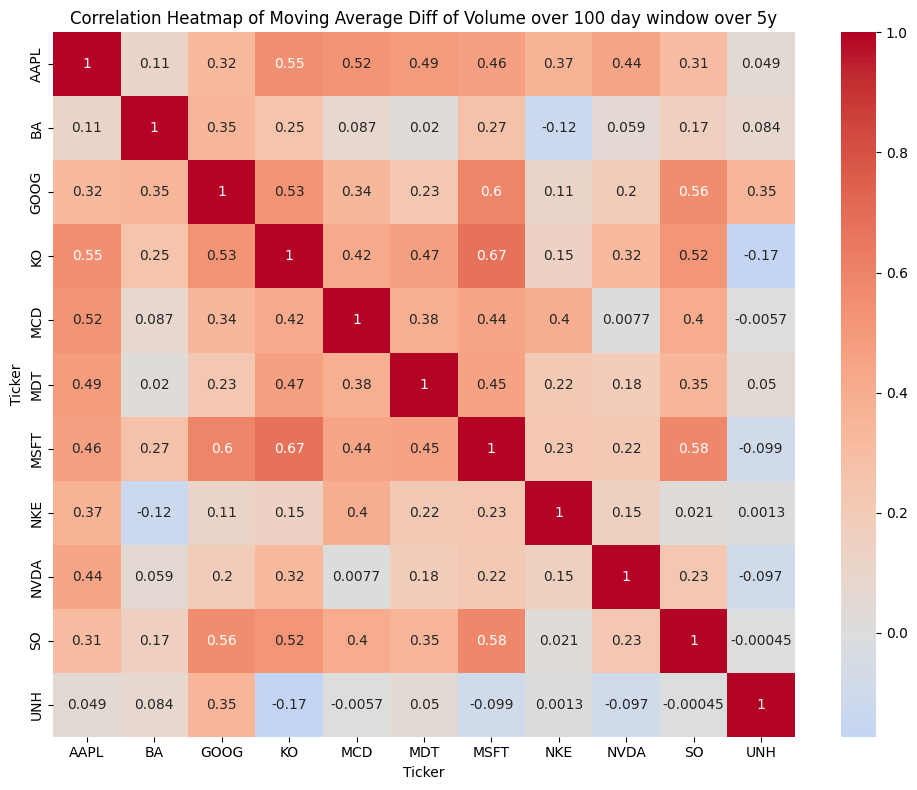

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation Heatmap of Moving Average Diff of {feature} over {window} day window over {test.timePeriod}' )
plt.tight_layout()
plt.show()

In [ ]:
feature = 'Volume'
returns = bigTest.MovingAverages(feature,window)[('Diff',)]
summary_stats = returns.describe().T
summary_stats['skew'] = returns.skew()
summary_stats['kurtosis'] = returns.kurtosis()
corr_matrix = returns.corr()
cov_matrix = returns.cov()

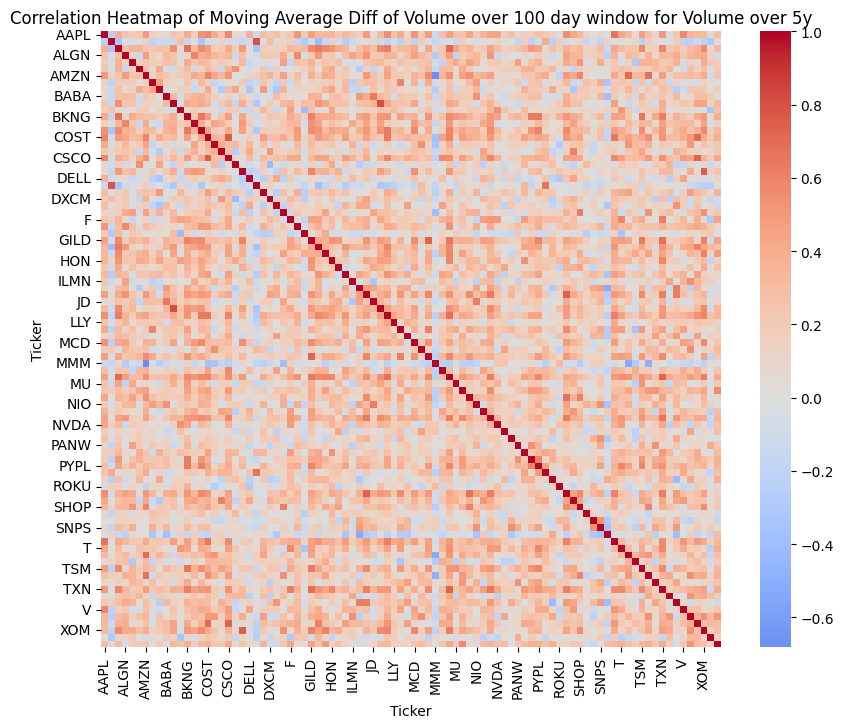

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title(f'Correlation Heatmap of Moving Average Diff of {feature} over {window} day window for Volume over {bigTest.timePeriod}' )
plt.show()

In [ ]:
bigTest.change_timePeriod('5y')

[*********************100%***********************]  90 of 90 completed


In [ ]:
feature = 'Close'
df = test.MovingAverages(feature,70)[('Diff',)]
fig = px.line(df, x = df.index, y = df.columns[:4], title = f'Moving Average diff over 70 day window for {feature} over {bigTest.timePeriod}')
fig.show()

In [ ]:
feature = 'Volume'
df = test.MovingAverages(feature,70)[('Diff',)]
fig = px.line(df, x = df.index, y = df.columns[:4], title = f'Moving Average diff over 70 day window for {feature} over {bigTest.timePeriod}')
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score


In [ ]:
def LinearRegModel(testDf,targetDf,ticker,targetDay):
  X_train, X_test, y_train, y_test = train_test_split(testDf, targetDf, test_size=0.2)
  standXTest,standXtrain = standardize(X_test,X_train)
  standYTest,standYtrain = standardize(y_test,y_train)
  # Initialize the model
  model = LinearRegression()
  X_train = standXtrain.sort_index()
  y_train = standYtrain.sort_index()
  X_test = standXTest.sort_index()
  y_test = standYTest.sort_index()
  # Train the model

  model.fit(X_train, y_train)

  # Predict on the test data
  y_pred = model.predict(X_test)
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"For ticker: {ticker}")
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"R^2 Score: {r2:.2f}")
  standTestDf, standTargetDf = standardize(testDf,targetDf)
  allPred = model.predict(standTestDf)
  PredPriceForNextDay = allPred[len(allPred)- 1]*targetDf.std().iloc[0]+targetDf.mean().iloc[0]
  print(PredPriceForNextDay)

In [ ]:
movingAverageWindow = 14
dayshift = 1 #This is to choose which day we want to predict, we're looking at the tail
# of length dayshift of our dataframe then we choose [0]
targetFeature = 'Close'
sampleSize = 650 #randomly selecting this many days from history
DaysBack = 100 #from our target days we are looking at the history this many days back
#so for nov 30th days back would correspond with nov16th data point
print(f"Results for Linear Regression Model, \nMSE, R^2, and predicted {targetFeature} price {DaysBack} days from now\nWith Moving Avg Window of {movingAverageWindow},{movingAverageWindow*2}, and {movingAverageWindow*5} days")
for ticker in test.tickerList:
    diff = test.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
    diffShifted2X = test.MovingAverages('Close',movingAverageWindow*2)[('Diff',ticker)].dropna()
    diffShifted5X = test.MovingAverages('Close',movingAverageWindow*5)[('Diff',ticker)].dropna()
    #volDiff = test.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
    logReturn = test.getLogChangeHistory('Close')[ticker].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
    #volumeData = test.data[('Volume',ticker)].tail(len(test.data[('Volume',ticker)]) - movingAverageWindow + 1)
    closeData = test.data[('Close',ticker)].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1)
    openData = test.data[('Open', ticker)].tail(len(test.data[('Open',ticker)]) - movingAverageWindow + 1)
    lowData = test.data[('Low', ticker)].tail(len(test.data[('Low',ticker)]) - movingAverageWindow + 1)
    highData = test.data[('High', ticker)].tail(len(test.data[('High',ticker)]) - movingAverageWindow + 1)
    #testDay = [diff.tail(dayshift).iloc[0],volDiff.tail(dayshift).iloc[0],logReturn.tail(dayshift).iloc[0],volumeData.tail(dayshift).iloc[0],closeData.tail(dayshift).iloc[0],openData.tail(dayshift).iloc[0],
    #           lowData.tail(dayshift).iloc[0],highData.tail(dayshift).iloc[0]]
    nonShiftedTestDf = pd.DataFrame({'LogReturn': logReturn,
                                     'MovingAvgDiffClose':diff,
                                     'Shifted2xMovingAvg':diffShifted2X,
                                     'Shifted5xMovingAvg':diffShifted5X,
                                     #'MovingAvgDiffVol': volDiff,
                                     #'Volume':volumeData,
                                     'Close':closeData,
                                     'Open':openData,
                                     'Low':lowData,
                                     'High':highData})
    testDf,targetDf = test.featureAndTargetSplitter(DaysBack, sampleSize, targetFeature,movingAverageWindow, ticker )
    #testDay = (testDay - np.array(list(nonShiftedTestDf.mean())))/np.array(list(nonShiftedTestDf.std()))
    targetDay = test.data[(targetFeature,ticker)].tail(DaysBack).iloc[0]
    LinearRegModel(testDf,targetDf,ticker,targetDay)


Results for Linear Regression Model, 
MSE, R^2, and predicted Close price 100 days from now
With Moving Avg Window of 14,28, and 70 days
For ticker: MSFT
Mean Squared Error: 0.34
R^2 Score: 0.65
[520.48727779]
For ticker: AAPL
Mean Squared Error: 0.47
R^2 Score: 0.52
[214.43004374]
For ticker: GOOG
Mean Squared Error: 0.49
R^2 Score: 0.50
[197.92724855]
For ticker: UNH
Mean Squared Error: 0.74
R^2 Score: 0.26
[402.54006334]
For ticker: NVDA
Mean Squared Error: 0.17
R^2 Score: 0.83
[203.53746737]
For ticker: KO
Mean Squared Error: 0.65
R^2 Score: 0.34
[67.38964065]
For ticker: BA
Mean Squared Error: 0.90
R^2 Score: 0.09
[202.86232442]
For ticker: MDT
Mean Squared Error: 0.34
R^2 Score: 0.65
[88.91430766]
For ticker: MCD
Mean Squared Error: 0.62
R^2 Score: 0.38
[292.591345]
For ticker: SO
Mean Squared Error: 0.34
R^2 Score: 0.66
[94.25339271]
For ticker: NKE
Mean Squared Error: 0.40
R^2 Score: 0.60
[76.55699049]


In [ ]:
ticker = 'NVDA'
diff = test.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
diffShifted2X = test.MovingAverages('Close',movingAverageWindow*2)[('Diff',ticker)].dropna()
diffShifted5X = test.MovingAverages('Close',movingAverageWindow*5)[('Diff',ticker)].dropna()
#volDiff = test.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
logReturn = test.getLogChangeHistory('Close')[ticker].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
#volumeData = test.data[('Volume',ticker)].tail(len(test.data[('Volume',ticker)]) - movingAverageWindow + 1)
closeData = test.data[('Close',ticker)].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1)
openData = test.data[('Open', ticker)].tail(len(test.data[('Open',ticker)]) - movingAverageWindow + 1)
lowData = test.data[('Low', ticker)].tail(len(test.data[('Low',ticker)]) - movingAverageWindow + 1)
highData = test.data[('High', ticker)].tail(len(test.data[('High',ticker)]) - movingAverageWindow + 1)
#testDay = [diff.tail(dayshift).iloc[0],volDiff.tail(dayshift).iloc[0],logReturn.tail(dayshift).iloc[0],volumeData.tail(dayshift).iloc[0],closeData.tail(dayshift).iloc[0],openData.tail(dayshift).iloc[0],
#           lowData.tail(dayshift).iloc[0],highData.tail(dayshift).iloc[0]]
nonShiftedTestDf = pd.DataFrame({'LogReturn': logReturn,
                                  'MovingAvgDiffClose':diff,
                                  'Shifted2xMovingAvg':diffShifted2X,
                                  'Shifted5xMovingAvg':diffShifted5X,
                                  #'MovingAvgDiffVol': volDiff,
                                  #'Volume':volumeData,
                                  'Close':closeData,
                                  'Open':openData,
                                  'Low':lowData,
                                  'High':highData})
nonShiftedTestDf

,LogReturn,MovingAvgDiffClose,Shifted2xMovingAvg,Shifted5xMovingAvg,Close,Open,Low,High
Date,,,,,,,,
2020-12-31,-0.006927,-0.063666,NaN,NaN,13.055000,13.136500,12.915000,13.151000
2021-01-04,0.004471,-0.068116,NaN,NaN,13.113500,13.104250,12.962500,13.652500
2021-01-05,0.021967,-0.033791,NaN,NaN,13.404750,13.099750,13.087000,13.443500
2021-01-06,-0.060762,-0.050181,NaN,NaN,12.614500,13.222500,12.586000,13.245000
2021-01-07,0.056220,-0.020550,NaN,NaN,13.344000,12.967500,12.886500,13.377750
...,...,...,...,...,...,...,...,...
2025-12-04,0.020884,0.811862,-4.532076,-1.587452,183.380005,181.619995,179.960007,184.520004
2025-12-05,-0.005304,1.330185,-4.371810,-1.587996,182.410004,183.889999,180.910004,184.660004
2025-12-08,0.017067,1.792684,-3.755109,-1.565686,185.550003,182.639999,182.399994,188.000000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
def RegTreeModel(testDf,targetDf,ticker,targetDay):
  X_train, X_test, y_train, y_test = train_test_split(testDf, targetDf, test_size=0.2)
  standXTest,standXtrain = standardize(X_test,X_train)
  standYTest,standYtrain = standardize(y_test,y_train)
  # Initialize the model
  model = RandomForestRegressor()
  # Prepare processed data for fitting and metrics
  X_train_processed = standXtrain.sort_index()
  y_train_processed = standYtrain.sort_index().values.ravel() # Convert to 1D array for fitting
  X_test_processed = standXTest.sort_index()
  y_test_processed = standYTest.sort_index().values.ravel() # Convert to 1D array for metrics

  # Train the model
  model.fit(X_train_processed, y_train_processed)

  # Predict on the test data
  y_pred = model.predict(X_test_processed)
  # Evaluate the model
  mse = mean_squared_error(y_test_processed, y_pred)
  r2 = r2_score(y_test_processed, y_pred)
  print(f"For ticker: {ticker}")
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"R^2 Score: {r2:.2f}")
  standTestDf, standTargetDf = standardize(testDf,targetDf)
  allPred = model.predict(standTestDf)
  PredPriceForNextDay = allPred[len(allPred)- 1]*targetDf.std().iloc[0]+targetDf.mean().iloc[0]
  print(PredPriceForNextDay)

In [ ]:
print(f"Results for Regression Tree Model, \nMSE, R^2, and predicted {targetFeature} price {DaysBack} days from now\nWith Moving Avg Window of {movingAverageWindow},{movingAverageWindow*2},and {movingAverageWindow*5} days")
for ticker in test.tickerList:
    diff = test.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
    diffShifted2X = test.MovingAverages('Close',movingAverageWindow*2)[('Diff',ticker)].dropna()
    diffShifted5X = test.MovingAverages('Close',movingAverageWindow*5)[('Diff',ticker)].dropna()
    #volDiff = test.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
    logReturn = test.getLogChangeHistory('Close')[ticker].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
    #volumeData = test.data[('Volume',ticker)].tail(len(test.data[('Volume',ticker)]) - movingAverageWindow + 1)
    closeData = test.data[('Close',ticker)].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1)
    openData = test.data[('Open', ticker)].tail(len(test.data[('Open',ticker)]) - movingAverageWindow + 1)
    lowData = test.data[('Low', ticker)].tail(len(test.data[('Low',ticker)]) - movingAverageWindow + 1)
    highData = test.data[('High', ticker)].tail(len(test.data[('High',ticker)]) - movingAverageWindow + 1)
    #testDay = [diff.tail(dayshift).iloc[0],volDiff.tail(dayshift).iloc[0],logReturn.tail(dayshift).iloc[0],volumeData.tail(dayshift).iloc[0],closeData.tail(dayshift).iloc[0],openData.tail(dayshift).iloc[0],
    #           lowData.tail(dayshift).iloc[0],highData.tail(dayshift).iloc[0]]
    nonShiftedTestDf = pd.DataFrame({'LogReturn': logReturn,
                                     'MovingAvgDiffClose':diff,
                                     'Shifted2xMovingAvg':diffShifted2X,
                                     'Shifted5xMovingAvg':diffShifted5X,
                                     #'MovingAvgDiffVol': volDiff,
                                     #'Volume':volumeData,
                                     'Close':closeData,
                                     'Open':openData,
                                     'Low':lowData,
                                     'High':highData})
    testDf,targetDf = test.featureAndTargetSplitter(DaysBack, sampleSize, targetFeature,movingAverageWindow, ticker )
    #testDay = (testDay - np.array(list(nonShiftedTestDf.mean())))/np.array(list(nonShiftedTestDf.std()))
    targetDay = test.data[(targetFeature,ticker)].tail(DaysBack).iloc[0]
    RegTreeModel(testDf,targetDf,ticker,targetDay)

Results for Regression Tree Model, 
MSE, R^2, and predicted Close price 100 days from now
With Moving Avg Window of 14,28,and 70 days
For ticker: MSFT
Mean Squared Error: 0.30
R^2 Score: 0.70
493.8561477952151
For ticker: AAPL
Mean Squared Error: 0.28
R^2 Score: 0.71
267.94305063176705
For ticker: GOOG
Mean Squared Error: 0.41
R^2 Score: 0.59
204.97472598426458
For ticker: UNH
Mean Squared Error: 0.64
R^2 Score: 0.36
332.5859220292633
For ticker: NVDA
Mean Squared Error: 0.11
R^2 Score: 0.89
179.3232927957937
For ticker: KO
Mean Squared Error: 0.59
R^2 Score: 0.40
70.44839501940758
For ticker: BA
Mean Squared Error: 0.90
R^2 Score: 0.09
211.08609804591413
For ticker: MDT
Mean Squared Error: 0.19
R^2 Score: 0.81
93.57122053098124
For ticker: MCD
Mean Squared Error: 0.62
R^2 Score: 0.38
296.74180829220194
For ticker: SO
Mean Squared Error: 0.40
R^2 Score: 0.60
89.85616985413732
For ticker: NKE
Mean Squared Error: 0.32
R^2 Score: 0.68
71.31718842697595


In [ ]:
pip install fredapi


# Alex Stuff

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os
import yfinance as yf
from fredapi import Fred
fred = Fred(api_key='a99f8e0301913988401acd5680bd2c05')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
#from reportlab.lib import colors
#from reportlab.lib.pagesizes import letter

In [ ]:
class Economic_Data():
    """Class that collects, processes, and merges economic indicators from FRED(Federal Reserve Bank),
    calculates economic momentum trends, and classifies economic cycles.

    Attributes are loaded at initialization so that all macro datasets are
    readily available for downstream ML modeling.
    """

    def __init__(self):
        self.fedTrate = self.get_fed_target_rate()
        self.UnempRate = self.get_unemployment_rate()
        self.gdp = self.get_gdp()
        self.cpi = self.get_CPI()
        self.baseReturnR = self.base_return_rate() #This benchmark will be used at the end, to make sure expected returns are enough
        self.cci = self.consumer_confidence_index()
        self.merged_data_df = self.merged_data_df()

        #_________________

    def calculate_momentum(self, data_column, lookback=3, rate_lookback=6):
        """
        Evaluate whether an economic series is rising, falling, or stable
        relative to an average.
        Rate data needs longer look back for extra data.
        """
        if data_column.name in ['Avg', 'Risk Free Returns']: #Used longer lookback for rates
            lookback = rate_lookback

        #If we get a column for the pandas df that does not have enough data:
        if len(data_column) < lookback + 1:
            return "Stable"

        current_value = data_column.iloc[-1]

        #Calculate the average of the previous lookback periods
        lookback_average = data_column.iloc[-lookback-1:-1].mean()

        #Threshold that reveals if change is great enough to show a change in economic trend
        threshold = 0.025

        if current_value > lookback_average + threshold:
            return "Rising"
        elif current_value < lookback_average - threshold:
            return "Falling"
        else:
            return "Stable"

            #_________________

    def get_fed_target_rate(self): #gets federal target rate which is calculated daily
        upper = fred.get_series('DFEDTARU', observation_start = '2018-01-01')
        lower = fred.get_series('DFEDTARL', observation_start = '2018-01-01')
        # Combine into one DataFrame
        rates = pd.DataFrame({'Upper': upper, 'Lower': lower})
        rates = rates.dropna()
        #Make a column with the average rate
        rates["Avg"] = (rates["Upper"] + rates["Lower"])/2
        rates.index.name = 'Date'

        return rates[["Avg"]]

        #_________________

    def get_unemployment_rate(self): #get unemployment rate calculated monthly
        UR = fred.get_series('UNRATE', observation_start='2018-01-01')
        UR_df = pd.DataFrame(UR)
        UR_df = UR_df.dropna()
        UR_df = UR_df.rename(columns = {0:"Unemployment Rate"})
        UR_df.index.name = 'Date'
        #UR_df['Unemp_Momentum'] = UR_df['Unemployment Rate'].apply(lambda x: self.calculate_momentum(UR_df['Unemployment Rate']))

        return UR_df

        #_________________

    def get_gdp(self): #this gets the real gdp which is calculated quarterly
        gdp = fred.get_series('GDPC1', observation_start='2018-01-01')
        # Convert to DataFrame
        gdp_df = pd.DataFrame(gdp) #this comes out in the tens of thousands
        gdp_df = gdp_df.dropna()
        gdp_df.rename(columns={0: 'Real-GDP/1,000,000'}, inplace=True)

        gdp_df["Annual Growth"] = gdp_df['Real-GDP/1,000,000'].pct_change(periods=4) *100
        gdp_df = gdp_df.dropna()
        gdp_df.index.name = 'Date'

        return gdp_df[["Annual Growth"]]

        #_________________

    def get_CPI(self): #gets consumer price index which is calculated monthly, and calculates the annual inflation rate
        data = fred.get_series('CPIAUCSL', observation_start='2018-01-01')
        # Convert to DataFrame
        cpi_data = pd.DataFrame(data)
        cpi_data = cpi_data.dropna()
        cpi_data.rename(columns={0: 'Consumer Price Index'}, inplace=True)
        cpi_data.index.name = 'Date'
        cpi_data["Inflation Rate"] = cpi_data["Consumer Price Index"].pct_change(periods = 12) *100
        cpi_data = cpi_data.dropna()

        return cpi_data[["Inflation Rate"]]

        #_________________

    def base_return_rate(self): #the rate of return of risk free treasury bonds, ie the benchmark we must beat
        treasury_yields = fred.get_series('DGS10', observation_start='2018-01-01')
        # Convert to DataFrame
        ty = pd.DataFrame(treasury_yields)
        ty = ty.dropna()
        ty.rename(columns={0: 'Risk Free Returns'}, inplace=True)
        ty.index.name = 'Date'
        return ty

        #_________________

    def consumer_confidence_index(self): #calculates the consumer confidence index on the economy -100/+100 range
        cci = fred.get_series('CSCICP03USM665S', observation_start='2008-01-01')

        # Convert to DataFrame
        CCI_df = pd.DataFrame(cci, columns=['Consumer Confidence Index'])
        CCI_df = CCI_df.dropna()
        CCI_df.index.name = 'Date'

        return CCI_df


        #_________________

    def cycle_classification_byrow(row):
        """
        Classifies the current economic cycle (Boom, Recession, Recovery, Stagflation)
        based on the latest macroeconomic data and the defined thresholds.
        """
        high_gdp = 2.5
        low_gdp = 1.0
        recession = 0.0

        #unemployment Thresholds
        high_une = 6.0
        low_une = 4.0

        #Inflation Thresholds
        high_inflation = 3.0     #above Fed target meaningfully
        moderate_inflation = 1.5 #typical level
        low_inflation = 0.5

        #Fed Rate Thresholds
        high_fed_rate = 3.0
        low_fed_rate = 1.5



        #Get the momentum for each row
        latest_gdp_growth = row['Annual Growth']
        gdp_momentum = row['GDP_mom']

        latest_unemployment = row['Unemployment Rate']
        unemp_momentum = row['Unemp_mom']

        latest_inflation = row['Inflation Rate']
        inflation_momentum = row['cpi_mom']

        latest_fed_rate = row['Avg']
        rate_momentum = row['ftr_mom']

        #set current economic cycle state to unknown
        current_cycle = "Unknown"


        #Recession: Negative growth and rising unemployment

        if latest_gdp_growth <= recession or \
           (gdp_momentum == "Falling" and unemp_momentum == "Rising"):
            current_cycle = "Recession/Contraction"

        #Stagflation: Low Growth, High Unemployment, High Inflation
        elif latest_gdp_growth <= low_gdp and \
             latest_unemployment >= high_une and \
             latest_inflation >= high_inflation:
            current_cycle = "Stagflation"

        #Late: High Growth, Low Unemployment, Rising Inflation/Rates
        elif latest_gdp_growth >= high_gdp and \
             latest_unemployment <= low_une and \
             (latest_inflation >= moderate_inflation or inflation_momentum == "Rising"):
            current_cycle = "Boom/Late Cycle"

        #Early/Recovery: Positive/Rising Growth, Falling Unemployment, Low/Stable Inflation
        elif latest_gdp_growth > 0 and \
             gdp_momentum == "Rising" and \
             unemp_momentum == "Falling" and \
             inflation_momentum != "Rising":   #stable or falling inflation is typical
            current_cycle = "Recovery/Early Cycle"


        #Default
        else:
            current_cycle = "Stable/Mid-Cycle"

        return current_cycle

        #_________________


    #creates the mega dataframe we will use to train the machine learning model:
    def merged_data_df(self):
        macro_data_dfs = [self.fedTrate, self.UnempRate, self.gdp, self.cpi, self.baseReturnR, self.cci]

        merge_df = pd.DataFrame(index = self.UnempRate.index)
        for dataframe in macro_data_dfs:
            merge_df = merge_df.join(dataframe, how = "outer")

        merge_df = merge_df.ffill()
        merge_df = merge_df.dropna()

        #Calculate the momentum of economic data to find trends and classify the economic cycle:
        #Make new columns with the averages of each data to find the baseline:
        merge_df['avg_gdp'] = merge_df["Annual Growth"].shift(1).rolling(3).mean()       #Shifting by one ensure we don't get
        merge_df['avg_unemp'] = merge_df["Unemployment Rate"].shift(1).rolling(3).mean() #bias on future data
        merge_df['avg_cpi'] = merge_df["Inflation Rate"].shift(1).rolling(3).mean()
        merge_df['avg_rates'] = merge_df["Avg"].shift(1).rolling(6).mean()

        #Momentum Threshold:
        mom_threshold = 0.015

        #GDP:
        merge_df["GDP_mom"] = merge_df.apply(lambda row:
                                             "Rising" if row ['Annual Growth'] > row['avg_gdp'] + mom_threshold else
                                            ('Falling' if row['Annual Growth'] < row['avg_gdp'] - mom_threshold else 'steady'), axis = 1)

        #Unemployment rate:
        merge_df["Unemp_mom"] = merge_df.apply(lambda row:
                                             "Rising" if row ['Unemployment Rate'] > row['avg_unemp'] + mom_threshold else
                                            ('Falling' if row['Unemployment Rate'] < row['avg_unemp'] - mom_threshold else 'steady'), axis = 1)

        #CPI:
        merge_df["cpi_mom"] = merge_df.apply(lambda row:
                                             "Rising" if row ["Inflation Rate"] > row['avg_cpi'] + mom_threshold else
                                            ('Falling' if row["Inflation Rate"] < row['avg_cpi'] - mom_threshold else 'steady'), axis = 1)

        #Federal Target Rates:
        merge_df["ftr_mom"] = merge_df.apply(lambda row:
                                             "Rising" if row ['Avg'] > row['avg_rates'] + mom_threshold else
                                            ('Falling' if row['Avg'] < row['avg_rates'] - mom_threshold else 'steady'), axis = 1)

        merge_df = merge_df.dropna()
        #Add a column with the economic state (stage of the cycle) for each month
        merge_df['Economic_State'] = merge_df.apply(Economic_Data.cycle_classification_byrow, axis = 1)
        merge_df.index.name = "Date" #the index of the df are the dates so we can align them later on.

        #delete unnecessary columns from the dataframe:
        drop_cols = [col for col in merge_df.columns if "_Avg" in col or "Real-GDP/1,000,000" in col or "Consumer Price Index" in col]
        drop_cols2 = ["avg_gdp", "avg_unemp", "avg_cpi", "avg_rates", "GDP_mom", "Unemp_mom", "cpi_mom", "ftr_mom"]

        merge_df = merge_df.drop(columns = drop_cols)
        merge_df = merge_df.drop(columns = drop_cols2)
        return merge_df

        #_________________

    def determine_current_cycle(self):
        """Returns the classified stage of the economic cycle for the latest available date."""
        if not self.merged_data_df.empty:
            return self.merged_data_df['Economic_State'].iloc[-1]
        return "Data Not Loaded"

In [ ]:
y = Economic_Data()
y.merged_data_df

,Avg,Unemployment Rate,Annual Growth,Inflation Rate,Risk Free Returns,Consumer Confidence Index,Economic_State
Date,,,,,,,
2019-01-07,2.375,4.0,1.933559,1.487589,2.70,101.00890,Stable/Mid-Cycle
2019-01-08,2.375,4.0,1.933559,1.487589,2.73,101.00890,Stable/Mid-Cycle
2019-01-09,2.375,4.0,1.933559,1.487589,2.74,101.00890,Stable/Mid-Cycle
2019-01-10,2.375,4.0,1.933559,1.487589,2.74,101.00890,Stable/Mid-Cycle
2019-01-11,2.375,4.0,1.933559,1.487589,2.71,101.00890,Stable/Mid-Cycle
...,...,...,...,...,...,...,...
2025-12-06,3.875,4.4,2.080467,3.022700,4.14,98.91297,Stable/Mid-Cycle
2025-12-07,3.875,4.4,2.080467,3.022700,4.14,98.91297,Stable/Mid-Cycle
2025-12-08,3.875,4.4,2.080467,3.022700,4.17,98.91297,Stable/Mid-Cycle


In [ ]:
def next_return_col(ticker):
    """Name for 'next month return' target column."""
    return f"{ticker}_NextReturn"


class PortfolioDataProcessor:
    """
    Downloads stock price data, computing monthly returns,
    merging stock returns with macroeconomic data, and preparing the
    final DataFrame for training predictive models.
    tickers:
        List of stock ticker symbols to download.
    macro_df:
        pre-processed macroeconomic dataset from Economic_Data.

    all_returns_df:pd.DataFrame
        Monthly stock return data for the selected tickers.
    final_training_df:
        The merged dataset combining macroeconomic and stock return data.
    """
    def __init__(self, tickers, macro_data_instance):
        self.tickers = tickers
        self.macro_df = macro_data_instance.merged_data_df.copy()
        self.all_returns_df = self.get_stock_returns()
        self.final_training_df = self.merge_macro_and_market_data()

    def get_stock_returns(self):
        """
        Downloads adjusted stock prices using yfinance, converts them to
        monthly returns, and standardizes column names.
        Returns: A pd df of monthly percentage returns for each ticker.
        """
        print(f"Your Selected Securities: {self.tickers}...")

        #Use earliest macro date as start point for stock data
        start_date = self.macro_df.index.min().strftime('%Y-%m-%d')

        try:
            #Download all of the stock data from the yfinance API
            raw_data = yf.download(self.tickers, start=start_date, progress=False, auto_adjust=False)
            #Raise a value error if the API stopped working or if the stocks inputted don't have any data
            if raw_data.empty:
                raise ValueError("yfinance returned empty DataFrame.")

            #Extract data from different yfinance formats (single vs multi-ticker):
            #Extract the adjusted closing price of the stock robustly
            if len(self.tickers) == 1:
                if 'Adj Close' in raw_data.columns:
                    prices = raw_data[['Adj Close']].rename(columns={'Adj Close': self.tickers[0]})
                elif 'Close' in raw_data.columns:
                    prices = raw_data[['Close']].rename(columns={'Close': self.tickers[0]})
                else:
                    raise KeyError("Could not find price columns.")
            else:
                #MultiIndex: level 0 = field, level1 = ticker
                if 'Adj Close' in raw_data.columns.get_level_values(0):
                    prices = raw_data.xs('Adj Close', axis=1, level=0)
                else:
                    #fallback to Closing price
                    prices = raw_data.xs('Close', axis=1, level=0)
            #drop the tickers that only contain NA
            prices = prices.dropna(axis=1, how='all')
            if prices.empty:
                raise ValueError("All tickers dropped due to lack of data.")
        except Exception as e:
            print("Error downloading price data:", e)
            return pd.DataFrame()

        #Resample to month end and compute percent returns since macro data is monthly
        monthly_prices = prices.resample('ME').last()
        monthly_returns = monthly_prices.pct_change() * 100.0 #how much a stock returned for that month

        #standardize column names to ticker_Return
        monthly_returns.columns = [f"{col}_Return" for col in monthly_returns.columns]
        #Drops the first na row created by pct_change()
        monthly_returns = monthly_returns.dropna()

        print("Successfully calculated returns.")

        return monthly_returns

    def merge_macro_and_market_data(self):
        """
        Merge monthly macroeconomic data with stock monthly returns into a single dataset.
        Return: Final merged DataFrame that we can train ML models on.
        """
        if self.all_returns_df.empty or self.macro_df.empty:
            print("Cannot merge: stock or macro data empty.")
            return pd.DataFrame()
        #Align indexes and join inner (only months where both exist)
        macro = self.macro_df.copy()
        #ONE-HOT encode 'Economic_State' (changes category of economic state to a number that can be used)
        if 'Economic_State' in macro.columns:
            macro = pd.get_dummies(macro, columns=['Economic_State'], prefix='Cycle')
        final_df = macro.join(self.all_returns_df, how='inner')
        final_df = final_df.dropna()  # drop any remaining NaNs
        print(f"Final df shape: {final_df.shape}")
        return final_df

In [ ]:
macro_data = Economic_Data()

my_tickers = ['SPY', 'QQQ', 'IWM', "SPY", "AAPL", "MSFT", "GOOGL",  "TSLA", "JNJ",'COKE', 'JPM']

processor = PortfolioDataProcessor(tickers=my_tickers, macro_data_instance=macro_data)
processor.merge_macro_and_market_data()

Your Selected Securities: ['SPY', 'QQQ', 'IWM', 'SPY', 'AAPL', 'MSFT', 'GOOGL', 'TSLA', 'JNJ', 'COKE', 'JPM']...
Successfully calculated returns.
Final df shape: (82, 20)
Final df shape: (82, 20)


,Avg,Unemployment Rate,Annual Growth,Inflation Rate,Risk Free Returns,Consumer Confidence Index,Cycle_Boom/Late Cycle,Cycle_Recession/Contraction,Cycle_Recovery/Early Cycle,Cycle_Stable/Mid-Cycle,AAPL_Return,COKE_Return,GOOGL_Return,IWM_Return,JNJ_Return,JPM_Return,MSFT_Return,QQQ_Return,SPY_Return,TSLA_Return
Date,,,,,,,,,,,,,,,,,,,,
2019-02-28,2.375,3.8,1.933559,1.518862,2.73,101.06190,False,False,False,True,4.477631,14.856367,0.058614,5.179096,3.356050,0.830932,7.735742,2.991185,3.241608,4.188647
2019-03-31,2.375,3.8,1.933559,1.883186,2.41,101.27530,False,False,False,True,9.702574,16.126049,4.468521,-2.093297,2.305325,-2.999238,5.275390,3.924579,1.810025,-12.510939
2019-04-30,2.375,3.7,2.242126,2.000583,2.51,101.43180,False,False,False,True,5.643594,13.012491,1.875284,3.396717,1.008655,15.517132,10.734241,5.499287,4.085248,-14.710924
2019-05-31,2.375,3.6,2.242126,1.795911,2.14,101.51780,False,False,False,True,-12.421283,-7.082436,-7.711685,-7.852681,-6.482041,-8.694513,-4.948049,-8.225184,-6.377101,-22.426582
2019-06-30,2.375,3.6,2.242126,1.671195,2.00,101.42600,False,False,False,True,13.051893,-0.913881,-2.141888,6.984877,6.199007,5.511480,8.311771,7.590037,6.958652,20.684813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-31,4.375,4.2,2.080467,2.731801,4.37,98.91297,False,False,False,True,1.169770,0.313857,8.891783,1.668287,7.849421,2.675713,7.255580,2.423689,2.303151,-2.955995
2025-08-31,4.375,4.3,2.080467,2.939220,4.23,98.91297,False,False,False,True,11.963886,4.912754,10.948414,7.192671,8.334607,1.748593,-4.869173,0.953971,2.051956,8.304411
2025-09-30,4.125,4.4,2.080467,3.022700,4.16,98.91297,False,False,False,True,9.688125,-0.068235,14.281830,3.179118,4.656546,4.647994,2.222270,5.376216,3.562036,33.201548


In [ ]:
def evaluate_model(model_pipeline, df, ticker, feature_cols, eval_mode='in_sample'):
    """
    Evaluate a trained machine learning model on stock return data.
    Parameters:
    - model_pipeline : sklearn Pipeline or estimator
        A trained model that supports .predict(X).
    - df : The dataset containing macro features and stock returns.
    ticker : The ticker symbol being evaluated
    feature_cols : List of feature column names used for model prediction.
    eval_mode : str, optional
        'in_sample'  - predict on the same data the model was trained on.
        'one_step'   - simulate real forecasting by predicting 1 step ahead
                       without retraining.
    Return:
    tuple: (mse, r2) : numerical evaluation metrics.
    """
    #Ensure economic state is one hot encoded
    if 'Economic_State' in df.columns: #
        df = pd.get_dummies(df, columns=['Economic_State'], prefix='Cycle')
    #predict model on the same data used to train
    if eval_mode == 'in_sample':

        #makes the column of the ticker's return
        target_col = f"{ticker}_Return"
        if target_col not in df.columns:
            print(f"{target_col} missing in df.")
            return None
        X = df[feature_cols]
        y = df[target_col]
        y_pred = model_pipeline.predict(X)
    elif eval_mode == 'one_step':
        #Build one-step-ahead prediction using the pipeline without retraining)
        #This expects the pipeline is already trained on appropriate data
        #We predict X.iloc[:-1], compare to y.iloc[1:] (obs vspred )
        target_col = f"{ticker}_Return"
        if target_col not in df.columns or len(df) < 3:
            print("Not enough stock data and/or missing target for one-step evaluation.")
            return None

        #Feature matrix X and target vector y
        X = df[feature_cols]
        y = df[target_col]

        #Predictions using pipeline
        #Predict all but last row => these predictions should align with y[1:]
        y_pred = model_pipeline.predict(X.iloc[:-1])

        #Shift the true values forward by one period
        y = y.iloc[1:]  #prediction for next period
        y_pred = pd.Series(y_pred, index=y.index)
    else:
        raise ValueError("eval_mode must be 'in_sample' or 'one_step'")

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"{ticker} | eval_mode={eval_mode} | R2={r2:.4f} | MSE={mse:.4f}")

    #plot actual vs predicted returns
    plt.figure(figsize=(12,5))
    plt.plot(y.index, y, label='Actual', marker='o')
    plt.plot(y.index, y_pred, label='Predicted', linestyle='--', marker='x')
    plt.title(f"{ticker} Actual vs Predicted Returns ({eval_mode})")
    plt.ylabel("Return (%)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.show()

    #plot (error = actual - predicted)
    residuals = y - y_pred
    plt.figure(figsize=(12,4))
    plt.plot(y.index, residuals, marker='o')
    plt.axhline(0, linestyle='--')
    plt.title(f"{ticker} Residuals ({eval_mode})")
    plt.ylabel("Error (%)")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

    return mse, r2

In [ ]:
def measure_forecast_accuracy(tickers, lookback_years=1, base_model_params=None):
    """
    Perform pipeline validation to evaluate predictive model accuracy.
    Each step:
        - Train a RandomForest model on all data up to time t.
        - Predict return at time t+1.
        - Record predicted, actual, and whether prediction direction was correct.
    Parameters:
    tickers : List of stock tickers to forecast.
    lookback_years : How many past years to include in walk-forward evaluation.
    base_model_params : Parameters for RandomForestRegressor ML model(n_estimators, max_depth, etc.)

    Returns - results_df : Contains predicted returns, actual returns, and directional accuracy.
    """
    #Default RandomForest parameters
    if base_model_params is None:
        base_model_params = {'n_estimators': 200, 'max_depth': 5, 'random_state': 42}
    #macro-data df
    macro_data = Economic_Data()
    #meg df with ticker information
    processor = PortfolioDataProcessor(tickers, macro_data)
    #make a copy to prevent altering original
    df = processor.final_training_df.copy()
    if df.empty:
        print("No data available.")
        return pd.DataFrame()

    #Feature columns: everything that is not a ticker return
    #Only uses columns that don't end with '_Return'
    feature_cols = [c for c in df.columns if not c.endswith('_Return')]

    #__________________________________________________________________________________________________
    months_to_test = int(lookback_years * 12) #how many months to predict
    start_index = len(df) - months_to_test
    if start_index < 24:
        start_index = 24  # require at least 2 years to train initially
    #__________________________________________________________________________________________________
    results = []
    for i in range(start_index, len(df) - 1):
        train_df = df.iloc[:i+1].copy()  #up to time t
        predict_row = df.iloc[[i+1]].copy()  #row for t+1 (to compare)
        for ticker in tickers:
            #Prepare training target: shifted next-return
            target = next_return_col(ticker)

            #create next month's target
            train_df[target] = train_df[f"{ticker}_Return"].shift(-1)
            #tried to do weekly results and failed terribly.
            #its best to stick with monthly predictions since we want investors to be comfortable in the long run
            #train_df[target] = train_df[f"{ticker}_Return"].pct_change(5)

            #drop last row in train_df because we don't know its next value
            train_clean = train_df.iloc[:-1].dropna(subset=[target])
            if train_clean.empty:
                continue
            X_train = train_clean[feature_cols]
            y_train = train_clean[target]

            #Build model pipeline: standardize features + RandomForest
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(**base_model_params))
            ])
            pipe.fit(X_train, y_train)
            #Predict using only the latest available macro features, time t
            X_pred = train_df[feature_cols].iloc[[-1]]
            pred = pipe.predict(X_pred)[0]
            actual = predict_row[f"{ticker}_Return"].values[0] #actual return of stock
            results.append({
                'Date': df.index[i+1],
                'Ticker': ticker,
                'Predicted': pred,
                'Actual': actual,
                'Correct_Direction': (pred > 0) == (actual > 0)
            })

        #make results into df
    results_df = pd.DataFrame(results)
    if results_df.empty:
        print("No forecasts generated.")
        return results_df

    #Compute overall metrics
    dir_acc = results_df['Correct_Direction'].mean() * 100
    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    print(f"Directional Accuracy: {dir_acc:.2f}%")
    print(f"MAE: {mae:.4f}%")

    #Ticker summary
    summary = results_df.groupby('Ticker').apply(lambda x: pd.Series({
        'Directional Acc (%)': x['Correct_Direction'].mean() * 100,
        'Avg Error (%)': mean_absolute_error(x['Actual'], x['Predicted'])
    }))
    display(summary)


    plt.figure(figsize=(10,6))
    colors = ['green' if v else 'red' for v in results_df['Correct_Direction']]
    plt.scatter(results_df['Actual'], results_df['Predicted'], c=colors, alpha=0.6)
    lim = max(abs(results_df['Actual']).max(), abs(results_df['Predicted']).max()) * 1.1
    plt.plot([-lim, lim], [-lim, lim], 'k--', alpha=0.6)
    plt.axhline(0, color='gray')
    plt.axvline(0, color='gray')
    plt.xlabel('Actual Return (%)')
    plt.ylabel('Predicted Return (%)')
    plt.title('Forward_Prediction: Predicted vs Actual')
    plt.grid(True, alpha=0.3)
    plt.show()

    return results_df

In [ ]:
def predict_and_allocate(tickers, initial_capital, min_pred_threshold=0.25, base_model_params=None):
    """
    Trains a pipeline for each ticker on all available history, predicts the next month's return using the latest macro row only to avoid leakage,
    and allocates capital proportionally across tickers with positive predicted returns.
    Parameters: min_pred_threshold: percent return threshold
    """

    #set default parameters for random forest, unless given otherwise
    if base_model_params is None:
        base_model_params = {'n_estimators': 200, 'max_depth': 5, 'random_state': 42}
    print(f"Allocation for ${initial_capital:,.2f}:")

    #Get the mega-dataframe with the macro-data and stock performance to train the random forest model
    macro_data = Economic_Data()
    processor = PortfolioDataProcessor(tickers, macro_data)
    df = processor.final_training_df.copy()
    if df.empty:
        print("No data.")
        return pd.DataFrame()

    feature_cols = [c for c in df.columns if not c.endswith('_Return')]  #hot-one encoded by processor earlier

    #Use the last available row for macro features (this is time t) which will be used to predict the next month's stocks direction
    latest_macro = df[feature_cols].iloc[[-1]]

    predictions = {}
    pipelines = {}
#For each ticker we do the following:
    for ticker in tickers:
        #Create training target (next-month return)
        target = next_return_col(ticker)
        #temporary copy of the dataframe with the necessary data
        temp = df.copy()

        #make the target the direction of the stock price next month
        temp[target] = temp[f"{ticker}_Return"].shift(-1)

        #tried to do weekly but failed
        #temp[target] = temp[f"{ticker}_WeeklyReturn"].shift(-1)
        train = temp.dropna(subset=[target]).copy()
        if train.empty:
            predictions[ticker] = 0.0 #predit zero change
            continue

        X = train[feature_cols]
        y = train[target]

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestRegressor(**base_model_params))
        ])
        pipe.fit(X, y)
        pipelines[ticker] = pipe

        pred = pipe.predict(latest_macro)[0]

        #threshold tiny predictions to avoid over-trading on noise
        if abs(pred) < min_pred_threshold:
            pred = 0.0

        predictions[ticker] = pred

    #Fetch current prices safely
    current_prices = {}
    for t in tickers:
        try:
            d = yf.download(t, period="7d", progress=False, auto_adjust=False)
            if not d.empty:
                #Prefer Adj Close if available
                if isinstance(d.columns, pd.MultiIndex):
                    #get latest Adj Close for ticker if multiindex
                    if 'Adj Close' in d.columns.get_level_values(0):
                        prices = d.xs('Adj Close', axis=1, level=0)
                        price = prices.iloc[-1].iloc[0] if prices.shape[1] >= 1 else prices.iloc[-1].iat[0]
                    else:
                        price = d['Close'].iloc[-1]
                else:
                    price = d['Adj Close'].iloc[-1] if 'Adj Close' in d.columns else d['Close'].iloc[-1]
                current_prices[t] = float(price)
            else:
                current_prices[t] = 0.0
        except Exception:
            current_prices[t] = 0.0

    #Promote user to only invest in tickers with positive predicted returns
    pos_preds = {k: v for k, v in predictions.items() if v > 0}
    total_pos = sum(pos_preds.values())

    allocation_plan = []
    #If all the stocks in your portfolio are expected to go down, it will recommend you liquidize your money and hold while markets
    #recover from the current down period.
    if total_pos == 0:
        print("No positive predictions above threshold. Hold cash/bonds (no allocation of capital on stocks recommended).")
    else:
        for t in tickers:
            #get ticker price otherwise the value and the return become 0
            curr_price = current_prices.get(t, 0.0)
            pred = predictions.get(t, 0.0)
            #invest in a stock if its price is obviously above 0 and the returns are expected to be positive.
            if pred > 0 and curr_price > 0:
                weight = pred / total_pos #What percent of capital should be allocated to this specific stock
                cash = initial_capital * weight #how much capital of the total should be spent.
                shares = np.floor(cash / curr_price)  #how many shares to buy
                invest_amt = shares * curr_price #Total money that will be spent on all of your shares

                #Add row on the dataframe for each stock with the information we just got.
                allocation_plan.append({
                    'Ticker': t,
                    'Current Price': curr_price,
                    'Pred. Return (%)': pred,
                    'Allocation %': weight * 100.0,
                    'Cash to Invest': invest_amt,
                    'Shares': shares
                })
            else:
                allocation_plan.append({
                    'Ticker': t,
                    'Current Price': curr_price,
                    'Pred. Return (%)': pred,
                    'Allocation %': 0.0,
                    'Cash to Invest': 0.0,
                    'Shares': 0.0
                })

    #dataframe with the predicted returns on investment. Make the returns descending so that the highest value returns are easily visible.
    results_df = pd.DataFrame(allocation_plan).sort_values('Pred. Return (%)', ascending=False)
    return results_df

In [ ]:
def print_out_report(df, filename="output.pdf"):
    pdf = SimpleDocTemplate(filename, pagesize=letter)
    #turn df into nested list
    data = [df.columns.tolist()] + df.values.tolist()
    #Table format
    table = Table(data)
    style = TableStyle([
        ('BACKGROUND', (0,0), (-1,0), colors.lightgrey),
        ('GRID', (0,0), (-1,-1), 0.5, colors.black),
        ('FONT', (0,0), (-1,-1), "Helvetica"),
        ('ALIGN', (0,0), (-1,-1), 'CENTER'),
        ('VALIGN', (0,0), (-1,-1), 'MIDDLE'),
    ])
    table.setStyle(style)

    #Put pdf together
    pdf.build([table])

    return filename

# Joseph:

In [ ]:
def read_holdings_csv_with_total(file_path):
    # Read CSV file
    df = pd.read_csv(file_path)

    # Drop rows where 'Ticker Symbol' is missing
    df = df.dropna(subset=['Ticker Symbol'])

    # Convert 'Holding' to numeric, coercing errors
    df['Holding'] = pd.to_numeric(df['Holding'], errors='coerce')

    # Drop rows with NaN in 'Holding' after conversion
    df = df.dropna(subset=['Holding'])

    # Reset index
    df = df.reset_index(drop=True)

    # Calculate total holdings
    total_holdings = df['Holding'].sum()

    return df, total_holdings

In [ ]:
csv_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSVMSgdtVWfNzOXeaok8xytcGMXRyZWhB-75jP-EHIBLp3BwxFZ3TLTO_74y0dbMmCqCi9kOm5auDoX/pub?gid=0&single=true&output=csv'
df , total = read_holdings_csv_with_total(csv_url)
test4 = StockPortfolio(list(df['Ticker Symbol'].values))

[*********************100%***********************]  6 of 6 completed


Price        Adj Close                                                 \
Ticker            AAPL        GOOG        MSFT        NVDA       RBLX   
Date                                                                    
2024-12-04  241.915878  175.322678  434.216888  145.098404  54.540001   
2024-12-05  241.945724  173.550430  439.378784  145.028412  58.939999   
2024-12-06  241.746628  175.720932  440.321838  142.408997  59.310001   
2024-12-09  245.639023  176.528320  442.753876  138.779755  56.930000   
2024-12-10  246.654449  185.927872  440.083588  135.040588  56.259998   
...                ...         ...         ...         ...        ...   
2025-11-26  277.549988  320.279999  485.500000  180.259995  92.730003   
2025-11-28  278.850006  320.119995  492.010010  177.000000  95.029999   
2025-12-01  283.100006  315.119995  486.739990  179.919998  93.790001   
2025-12-02  286.190002  316.019989  490.000000  181.460007  93.699997   
2025-12-03  284.149994  320.619995  477.730011  179.589996  92.099998   

Price                        Close                                      ...  \
Ticker            TSLA        AAPL        GOOG        MSFT        NVDA  ...   
Date                                                                    ...   
2024-12-04  357.929993  243.009995  176.089996  437.420013  145.139999  ...   
2024-12-05  369.489990  243.039993  174.309998  442.619995  145.059998  ...   
2024-12-06  389.220001  242.839996  176.490005  443.570007  142.440002  ...   
2024-12-09  389.790009  246.750000  177.100006  446.019989  138.809998  ...   
2024-12-10  400.989990  247.770004  186.529999  443.329987  135.070007  ...   
...                ...         ...         ...         ...         ...  ...   
2025-11-26  426.579987  277.549988  320.279999  485.500000  180.259995  ...   
2025-11-28  430.170013  278.850006  320.119995  492.010010  177.000000  ...   
2025-12-01  430.140015  283.100006  315.119995  486.739990  179.919998  ...   
2025-12-02  429.239990  286.190002  316.019989  490.000000  181.460007  ...   
2025-12-03  446.739990  284.149994  320.619995  477.730011  179.589996  ...   

Price             Open                                       Volume            \
Ticker            MSFT        NVDA       RBLX        TSLA      AAPL      GOOG   
Date                                                                            
2024-12-04  433.029999  142.000000  53.919998  353.000000  44383900  18239800   
2024-12-05  437.920013  145.110001  54.939999  359.869995  40033900  16145500   
2024-12-06  442.299988  144.600006  58.869999  377.420013  36870600  13319500   
2024-12-09  442.600006  138.970001  59.220001  397.609985  44649200  19887800   
2024-12-10  444.390015  139.009995  56.910000  392.679993  36914800  34317400   
...                ...         ...        ...         ...       ...       ...   
2025-11-26  486.309998  181.630005  92.169998  423.950012  33431400  29839600   
2025-11-28  487.600006  179.009995  93.610001  426.589996  20135600  19695800   
2025-12-01  488.440002  174.759995  93.010002  425.320007  46587700  28520600   
2025-12-02  486.720001  181.759995  94.190002  430.809998  53669500  24668200   
2025-12-03  476.320007  181.080002  92.154999  432.100006  43497200  32225800   

Price                                                
Ticker          MSFT       NVDA      RBLX      TSLA  
Date                                                 
2024-12-04  26009400  231224300   5883500  50810900  
2024-12-05  21697800  172621200  21008700  81403600  
2024-12-06  18821000  188505600   8964100  81455800  
2024-12-09  19144400  189308600   8585100  96359200  
2024-12-10  18469500  210020900   5277000  97563600  
...              ...        ...       ...       ...  
2025-11-26  25709100  183852000   6793400  63463000  
2025-11-28  14386700  121332800   3131300  36252900  
2025-12-01  23964000  188131000   6282500  57463600  
2025-12-02  19562700  182632200   6748800  69336600  
2025-12-03  34562900  164721400  

In [ ]:
feature = 'Close'
df = test4.MovingAverages(feature,14)[('Diff',)]
fig = px.line(df, x = df.index, y = df.columns[:5], title = f'Moving Average diff over 70 day window for {feature} over {bigTest.timePeriod}')
fig.show()

# Stuff Produced by Gemini, make sure to run the correct Stockportfolio class
## Modified featureAndTargetSplitter_KDays

### Subtask:
Inserts a new code cell with the `featureAndTargetSplitter_KDays` function. This function is a modified version of your original `featureAndTargetSplitter`. It now takes an additional parameter, `k_days_lookback`, to specify how many previous days' data should be included as features. It creates lagged versions of each financial metric (LogReturn, MovingAvgDiffClose, etc.) and combines them into a single wide feature DataFrame.


**Reasoning**:
The subtask requires replacing the existing `StockPortfolio` class with an updated version that includes the `featureAndTargetSplitter_KDays` method. This method will generate lagged features for a specified number of days.



In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf  # to fetch historical price data
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from sklearn.decomposition import PCA
# Step 1: Data Collection
import yfinance as yf
class StockPortfolio:
    '''
    This class is to help us manage data regarding a given list of stock tickers
    tickList: list or string of our stock tickers
    tickerList: Dictionary of our ticker names with the yf ticker object
    timePeriod: how far we want to look back on historical data,  must be one of: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max ,,, defaulting to 1 year
    data: A dataframe provided by yahoo finance api that gives us the daily open, close, adjusted close prices, highs and lows, and trading volume
            information for our tickers during a specified time period
    '''
    def __init__(self, tickList):
        self.tickerList = yf.Tickers(tickList).tickers
        self.timePeriod = '1y'
        self.data = yf.download(list(self.tickerList.keys()), period = self.timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
    def getSimpleChangeHistory(self, feature: str) -> pd.DataFrame:
        '''
        feature is what feature we want to see the % change in for that day, eg Close Price, Volume, Open Price
        This method calculates the daily closing price pct changes,
        calculated by taking the difference between the kth and (k-1)th day's non-adjusted closing price
        then dividing this difference by the (k-1)th close price to find the pct change after the kth day's market close
        '''
        #data = yf.download(list(self.YfTickers.keys()), period = timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
        self.simpleReturn = self.data[(feature,)].pct_change().dropna()
        return self.simpleReturn
    def getLogChangeHistory(self, feature: str) -> pd.DataFrame:
        '''
        This Method calculates the log return for each day, ln(Close Price of Today/close price of yesterday)
        '''
        self.logReturn = np.log(self.data[(feature,)]) - np.log(self.data[(feature,)].shift(1))
        return self.logReturn.dropna()
    def change_timePeriod(self, newTimePeriod: str) -> None:
        '''
        This method changes the time period for the historical data we want to look at
        '''
        self.timePeriod = newTimePeriod
        self.data = yf.download(list(self.tickerList.keys()), period = self.timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
        '''
    def simpleReturnVolatility(self) -> float:
        We Actually don't need this
        mean = self.getSimpleReturnHistory().mean()
        std = self.getSimpleReturnHistory().std()
        return std
    def logReturnVolatility(self) -> float:
        I don't think we need this either
        mean = self.getLogReturnHistory().mean()
        std = self.getLogReturnHistory().std()
        return std
        '''
    def simpleMovingAverage(self,  feature: str, dayWindow: int) -> pd.DataFrame:
        '''
        This method calculates the Simple Moving Average for a specific time window of our non-adjusted Close Prices
        '''
        return self.data[(feature, )].rolling(window = dayWindow).mean()
    def exponentialMovingAverage(self, feature: str, dayWindow: int) -> pd.DataFrame:
        '''
        feature: Any of the features of our stock data, examples: Volume Close Price

        This method calculates the exponential moving average for a specific time window of our non-adjusted Close Prices
        This one is more weighted by recent prices, so looking at the difference between the Simple Moving and Exponential moving
        can give some insight into the momentum of the price changes
        '''
        return self.data[(feature, )].ewm(span=dayWindow, adjust=False).mean()
    def extractColumns(self, cols:list,tick:list)->pd.DataFrame:
        newData = self.data.loc[:, (cols, tick)]
        return newData
    def plotMovingAveragesDiff(self,feature: str, timeWindow: int, ticker: str) -> go.Figure:
        '''
        This method creates a figure displaying the moving averages and their difference for a desired time window and ticker
        '''
        df1 = self.simpleMovingAverage(feature,timeWindow)
        df2 = self.exponentialMovingAverage(feature,timeWindow)
        df3 = self.exponentialMovingAverage(feature,timeWindow) - self.simpleMovingAverage(feature,timeWindow)
        newDf = pd.DataFrame()
        newDf['SMA'] = df1[ticker]
        newDf['EMA'] = df2[ticker]
        newDf['Diff'] = df3[ticker]
        fig = go.Figure()

        # Add SMA trace (primary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['SMA'], mode='lines', name='SMA'))

        # Add EMA trace (primary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['EMA'], mode='lines', name='EMA'))

        # Add Difference trace (secondary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['Diff'], mode='lines', name='Difference', yaxis='y2'))

        # Update layout for two y-axes
        diff_min = newDf['Diff'].min()
        diff_max = newDf['Diff'].max()
        padding = (diff_max - diff_min) * 0.1  # 10% padding
        fig.update_layout(
            title=f"Simple Moving Average and Exponential Moving Average of {ticker}'s {feature} over {timeWindow} day window, and Their Difference with Dual Y-Axis for {ticker}",
            xaxis=dict(title='Date'),
            yaxis=dict(title='SMA and EMA'),
            yaxis2=dict(
                title='Difference',
                overlaying='y',
                side='right',
                showgrid=False,
                zeroline=True,
                zerolinecolor='gray',
                range=[diff_min - padding, diff_max + padding]
            ),
            legend=dict(x=0, y=-1)
        )
        return fig
    def MovingAverages(self, feature: str, timeWindow: int) -> pd.DataFrame:
        df1 = self.simpleMovingAverage(feature,timeWindow)
        df2 = self.exponentialMovingAverage(feature,timeWindow)
        df3 = self.exponentialMovingAverage(feature,timeWindow) - self.simpleMovingAverage(feature,timeWindow)
        #combined = pd.concat([df1, df2, df3], axis=1, keys=['SMA', 'EMA', 'Diff'])
        #newDf[('SMA',)] = df1
        #newDf[('EMA',)] = df2
        #newDf[('Diff',)] = df3
        combined = pd.concat([df1, df2, df3], axis=1, keys=['SMA', 'EMA', 'Diff'])
        return combined
    def featureAndTargetSplitter(self, shift: int, sampleSize: int, targetFeature: str, movingAverageWindow: int, ticker ) -> (pd.DataFrame,pd.DataFrame):
        '''
        This method uses all of our data to construct our desired target and feature columns and offset the features by a shifted date to predict that many days in advance
        Sample Size is how many data points we want
        '''
        targetData = self.data[(targetFeature,ticker)].tail(len(self.data[(targetFeature,ticker)]) - movingAverageWindow + 1)
        '''
        feature column construction
        '''
        diff = self.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
        volDiff = self.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
        logReturn = self.getLogChangeHistory('Close')[ticker].tail(len(self.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
        volumeData = self.data[('Volume',ticker)].tail(len(self.data[('Volume',ticker)]) - movingAverageWindow + 1)
        closeData = self.data[('Close',ticker)].tail(len(self.data[('Close',ticker)]) - movingAverageWindow + 1)
        openData = self.data[('Open', ticker)].tail(len(self.data[('Open',ticker)]) - movingAverageWindow + 1)
        lowData = self.data[('Low', ticker)].tail(len(self.data[('Low',ticker)]) - movingAverageWindow + 1)
        highData = self.data[('High', ticker)].tail(len(self.data[('High',ticker)]) - movingAverageWindow + 1)

        #index = len(closeData)-2
        #testDay = {'Close':closeData.iloc[index],'Volume':volumeData.iloc[index],'LogReturn':logReturn.iloc[index],'MovingAvgDiffClose':diff.iloc[index],'MovingAvgDiffVol':volDiff.iloc[index]}
        '''
        Looking at the target column after the shift, so that we can then look at the previous indices for the feature columns
        '''
        subset_after_shift = targetData.iloc[shift:]
        sampled_df1 = subset_after_shift.sample(n=sampleSize, random_state=42)
        sampled_df1 = sampled_df1.sort_index()
        sampled_positions = [targetData.index.get_loc(idx) for idx in sampled_df1.index]
        shifted_positions = [pos - shift for pos in sampled_positions]
        valid_shifted_positions = [pos for pos in shifted_positions if pos >= 0]
        selectLogReturn = logReturn.iloc[valid_shifted_positions]
        selectedDiff = diff.iloc[valid_shifted_positions]
        selectVolDiff = volDiff.iloc[valid_shifted_positions]
        selectVolume = volumeData.iloc[valid_shifted_positions]
        selectClose = closeData.iloc[valid_shifted_positions]
        selectOpen = openData.iloc[valid_shifted_positions]
        selectLow = lowData.iloc[valid_shifted_positions]
        selectHigh = highData.iloc[valid_shifted_positions]
        testDf = pd.DataFrame({'LogReturn': selectLogReturn,'MovingAvgDiffClose':selectedDiff, 'MovingAvgDiffVol': selectVolDiff,'Volume':selectVolume,'Close':selectClose,'Open':selectOpen,'Low':selectLow, 'High':selectHigh})
        targetDf = pd.DataFrame({f'Target {targetFeature}':sampled_df1})
        return testDf, targetDf

    def featureAndTargetSplitter_KDays(self, shift: int, sampleSize: int, targetFeature: str, movingAverageWindow: int, ticker: str, k_days_lookback: int) -> (pd.DataFrame, pd.DataFrame):
        '''
        Modified version of featureAndTargetSplitter to include k_days_lookback for features.
        This method uses all of our data to construct our desired target and feature columns and offset the features by a shifted date to predict that many days in advance
        Sample Size is how many data points we want
        k_days_lookback: number of previous days to include as features (lagged values)
        '''
        # Ensure k_days_lookback is at least 1
        if k_days_lookback < 1:
            raise ValueError("k_days_lookback must be at least 1")

        targetData = self.data[(targetFeature, ticker)].tail(len(self.data[(targetFeature, ticker)]) - movingAverageWindow + 1)

        # Feature column construction
        diff = self.MovingAverages('Close', movingAverageWindow)[('Diff', ticker)].dropna()
      #  volDiff = self.MovingAverages('Volume', movingAverageWindow)[('Diff', ticker)].dropna()
        logReturn = self.getLogChangeHistory('Close')[ticker].tail(len(self.data[('Close', ticker)]) - movingAverageWindow + 1).dropna()
       # volumeData = self.data[('Volume', ticker)].tail(len(self.data[('Volume', ticker)]) - movingAverageWindow + 1)
        closeData = self.data[('Close', ticker)].tail(len(self.data[('Close', ticker)]) - movingAverageWindow + 1)
        openData = self.data[('Open', ticker)].tail(len(self.data[('Open', ticker)]) - movingAverageWindow + 1)
        lowData = self.data[('Low', ticker)].tail(len(self.data[('Low', ticker)]) - movingAverageWindow + 1)
        highData = self.data[('High', ticker)].tail(len(self.data[('High', ticker)]) - movingAverageWindow + 1)

        # Combine base features into a temporary DataFrame for lagging
        base_features = pd.DataFrame({
            'LogReturn': logReturn,
            'MovingAvgDiffClose': diff,
            #'MovingAvgDiffVol': volDiff,
            #'Volume': volumeData,
            'Close': closeData,
            'Open': openData,
            'Low': lowData,
            'High': highData
        })

        # Create lagged features
        lagged_features = pd.DataFrame()
        for col in base_features.columns:
            for i in range(k_days_lookback):
                lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)

        # Align target data with features after shifting
        # Looking at the target column after the shift, so that we can then look at the previous indices for the feature columns
        subset_after_shift = targetData.iloc[shift:]
        sampled_df1 = subset_after_shift.sample(n=sampleSize, random_state=42)
        sampled_df1 = sampled_df1.sort_index()

        # Get valid shifted positions for features based on sampled target indices
        sampled_target_indices = sampled_df1.index
        # Find the index of the first feature data point that can support all k_days_lookback lags
        first_valid_feature_date = lagged_features.index[lagged_features.notna().all(axis=1).argmax()]

        # Filter sampled_target_indices to ensure corresponding features are available and align with the shift
        valid_sampled_indices = []
        for target_date in sampled_target_indices:
            # The feature date should be 'shift' days before the target_date
            feature_date = target_date - pd.Timedelta(days=shift)
            if feature_date in lagged_features.index and feature_date >= first_valid_feature_date:
                valid_sampled_indices.append(target_date)

        # Filter sampled_df1 to only include valid target indices
        sampled_df1 = sampled_df1.loc[valid_sampled_indices]

        # Map valid sampled target indices back to the corresponding feature dates
        feature_indices_for_sampling = [idx - pd.Timedelta(days=shift) for idx in sampled_df1.index]

        # Select the corresponding lagged features
        testDf = lagged_features.loc[feature_indices_for_sampling].dropna()

        # Ensure targetDf also aligns after potential drops due to feature availability
        targetDf = pd.DataFrame({f'Target {targetFeature}': sampled_df1.loc[testDf.index + pd.Timedelta(days=shift)]})

        return testDf, targetDf

def standardize(testDf: pd.DataFrame, targetDf: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        '''
        Standardizes 2 pandas dataframes
        '''
        testDf = (testDf - testDf.mean())/testDf.std()
        targetDfmean = targetDf.mean()
        targetDfstd = targetDf.std()
        targetDf = (targetDf - targetDfmean) / targetDfstd
        return testDf, targetDf

In [ ]:
def LinearRegModel(testDf,targetDf,ticker,testDay,targetDay):
  X_train, X_test, y_train, y_test = train_test_split(testDf, targetDf, test_size=0.2)
  standXTest,standXtrain = standardize(X_test,X_train)
  standYTest,standYtrain = standardize(y_test,y_train)
  # Initialize the model
  model = LinearRegression()
  X_train = standXtrain.sort_index()
  y_train = standYtrain.sort_index()
  X_test = standXTest.sort_index()
  y_test = standYTest.sort_index()
  # Train the model

  model.fit(X_train, y_train)

  # Predict on the test data
  y_pred = model.predict(X_test)
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"For ticker: {ticker}")
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"R^2 Score: {r2:.2f}")
  standTestDf, standTargetDf = standardize(testDf,targetDf)
  allPred = model.predict(standTestDf)
  PredPriceForNextDay = allPred[len(allPred)- 1]*targetDf.std().iloc[0]+targetDf.mean().iloc[0]
  print(PredPriceForNextDay)

In [ ]:
test = StockPortfolio(['MSFT', 'AAPL','GOOG','UNH','NVDA','KO','BA','MDT','MCD','SO','NKE'])
test.change_timePeriod('5y')

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  11 of 11 completed
